       total_calories   total_mass
count     3262.000000  3262.000000
mean       255.012738   214.980074
std        219.637570   161.497428
min          0.000000     1.000000
25%         80.114996    92.000000
50%        209.110062   177.000000
75%        375.122963   305.000000
max       3943.325195  3051.000000


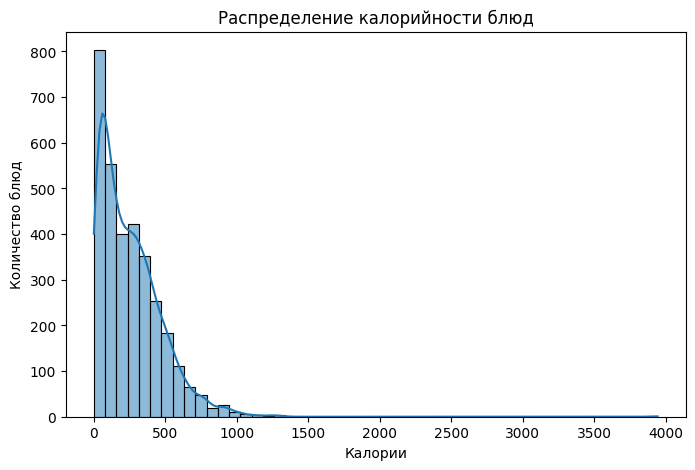

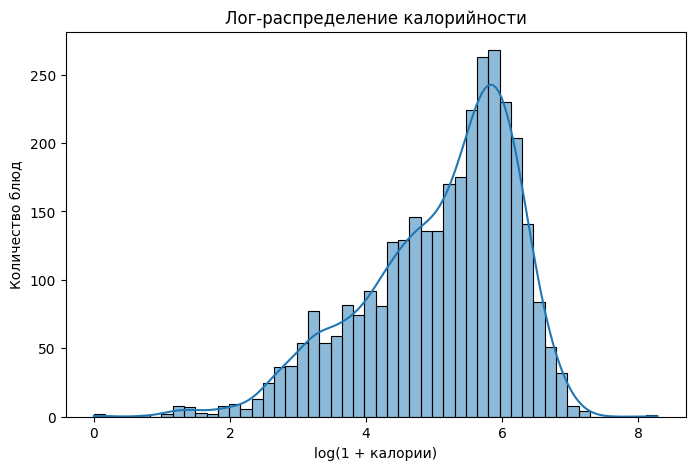

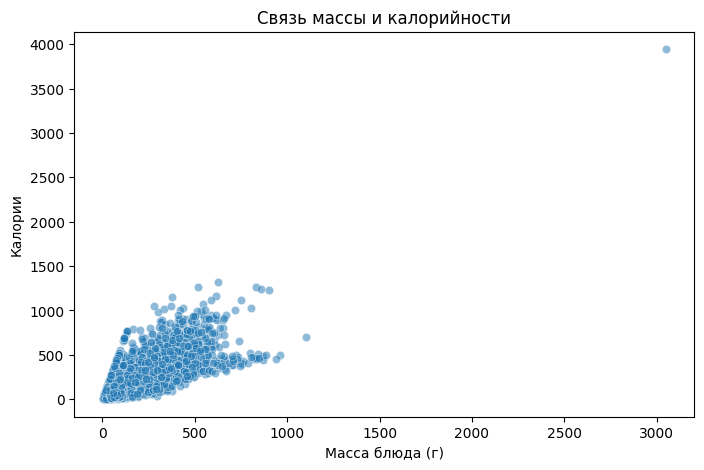

Корреляция между массой и калориями:
                 total_mass  total_calories
total_mass        1.000000        0.759676
total_calories    0.759676        1.000000
Статистика по количеству ингредиентов:
count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: num_ingredients, dtype: float64


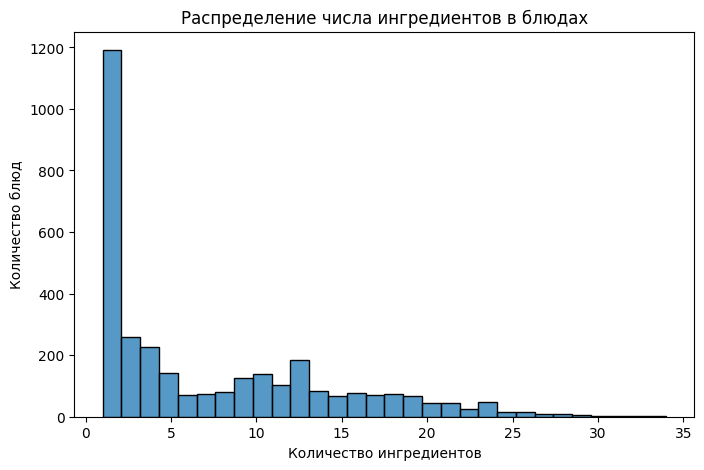

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Загружаем dish.csv ===
dish_df = pd.read_csv("data/dish.csv")  # замени путь
print(dish_df.describe())

# === Распределение целевой переменной ===
plt.figure(figsize=(8, 5))
sns.histplot(dish_df["total_calories"], bins=50, kde=True) # type: ignore
plt.title("Распределение калорийности блюд")
plt.xlabel("Калории")
plt.ylabel("Количество блюд")
plt.show()

# === Лог-гистограмма калорий ===
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(dish_df["total_calories"]), bins=50, kde=True)  # log1p = log(1+x), чтобы 0 не мешал
plt.title("Лог-распределение калорийности")
plt.xlabel("log(1 + калории)")
plt.ylabel("Количество блюд")
plt.show()

# === Scatterplot: масса vs калории ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x="total_mass", y="total_calories", data=dish_df, alpha=0.5)
plt.title("Связь массы и калорийности")
plt.xlabel("Масса блюда (г)")
plt.ylabel("Калории")
plt.show()

# === Корреляция ===
corr = dish_df[["total_mass", "total_calories"]].corr()
print("Корреляция между массой и калориями:\n", corr)

# === Среднее число ингредиентов ===
dish_df["num_ingredients"] = dish_df["ingredients"].apply(lambda x: len(x.split(";")))
print("Статистика по количеству ингредиентов:")
print(dish_df["num_ingredients"].describe())

# Гистограмма числа ингредиентов
plt.figure(figsize=(8, 5))
sns.histplot(dish_df["num_ingredients"], bins=30, kde=False) # type: ignore
plt.title("Распределение числа ингредиентов в блюдах")
plt.xlabel("Количество ингредиентов")
plt.ylabel("Количество блюд")
plt.show()



Была сделана нейросеть через кросс-модальное внимание.
Однако достичь задачи в <50 MAE не удается.
Максимум, который был достугнут 70 MAE. Были различные эксперементы с единым LR и отдельными по частям в моделях. С регуляризацией и безв разных местах.
С нормализацией в разных местах: в базовой модели на выход, в кросс-модальной модели перед входом в attention, после в регрессоре.
Самым удачным стал вариант с нормализацией в регрессоре + дропаут, все остальные нормализации выключены.
Ниже на скирине сравнение без нормализации (розовым цветом) и с нормализацией (зеленым)
тренировка
![alt text](<Снимок экрана 2025-08-25 011046.png>) 
валидация
![alt text](<Снимок экрана 2025-08-25 011336.png>) 
По итогу по ошибке валидации графики сошлись, однако с нормализацией график выгляди более лучше.

Были экспереметы с разыми вариациями:
![alt text](<Снимок экрана 2025-08-25 014512.png>)

Так и не смог понять, что именно надо сделать, что опустить ошибку ниже. Возможно, добавить двух-направленное внимание, но как будто не хватает прям мощного толчка.

В большм количестве эпох смысла не вижу, т.к трейн хоть и падал в конце чуть, но валидация начала барахтаться на одном месте, иногда даже расти.

ссылка на репозиторий, чтоб скришоты посмотреть и код - https://github.com/diyudd/multimodal_calory_dish

Подходы к обогащению/аугментации данных применяются самые стандартные.


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Твои скрины к сожалению не отображаются в ячейках.
</div>

<div class="alert alert-warning">
    
⚠️ Предлагаю такие шаги для достижения нужного результата (< 50 п. метрики `MAE`):
                                                               
1) Провести EDA данных: понять как выглядит распределение целевой метрики, есть ли выбросы в данных, для каких картинок характерны большие значения калорийности и тд
                                                               
2) После EDA я бы сконцентрировался на "картиночной" модели и попробовал бы с помощью нее достигнуть нужного качества.
                                                               
Также просьба скинуть репо с твоим проектом, так я смогу тебе помочь с более развернутой ОС.                                                           
                                                               
</div>

In [ ]:
import torch
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
import sys, os
sys.path.append("scripts")
from transformers import AutoTokenizer

from scripts.dataset import MultimodalDataset, collate_fn, get_transforms
from scripts.utils import CrossAttentionModel, MultimodalModel  
from scripts.config import Config 
from scripts.config import main
main()

d:\Нейросети яндекс практикум\multimodal_calory_dish\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClearML Task: overwriting (reusing) task id=015a7fd923064bf291558dcb2cf1be71
ClearML results page: https://app.clear.ml/projects/e0207a4e59484b31931844591cb879ca/experiments/015a7fd923064bf291558dcb2cf1be71/output/log
start
cuda
Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Ссылка на clearlm. (Почему то конфигурация не хочет подтягиваться на сайт)  https://app.clear.ml/projects/e0207a4e59484b31931844591cb879ca/experiments/015a7fd923064bf291558dcb2cf1be71/output/execution
</div>

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
    
⚠️ Возможно стоит поменять Loss функцию (например на RMSE). Так твоя модель может лучше сойтись.                                                      
                                                               
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Было L1Loss заменил на HuberLoss и также добавил scheduler = ReduceLROnPlateau и вроде как начало спасать при выходе на плато, но потом все ровно застряло
</div>

In [7]:
import torch
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
import sys, os
sys.path.append("scripts")
from transformers import AutoTokenizer

from scripts.dataset import MultimodalDataset, collate_fn, get_transforms
from scripts.utils import CrossAttentionModel, MultimodalModel  
from scripts.config import Config 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = Config()


model = CrossAttentionModel(config).to(device)
model.load_state_dict(torch.load(config.SAVE_PATH, map_location=device))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

2025-08-27 00:06:31,353 - clearml.model - INFO - Selected model id: af9ffbe9b1c643688650c1a32e0aabcd


In [9]:

test_transforms = get_transforms(config, ds_type="test")

test_dataset = MultimodalDataset(config, test_transforms, ds_type="test")

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer),
    num_workers=4,
    pin_memory=True
)

In [10]:
import torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
mae_metric = torchmetrics.MeanAbsoluteError().to(device)
mae_metric.reset()


all_preds = []
all_labels = []
all_indices = [] 
all_mass = []

with torch.no_grad():
    with torch.cuda.amp.autocast():
        for batch in test_loader:
            preds = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                image=batch["image"].to(device),
                mass=batch["mass"].to(device), 
            )
            labels = batch["label"].to(device)

            preds = preds.squeeze(-1)
            mae_metric.update(preds, labels)

            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
            all_mass.append(batch["mass"].detach().cpu().numpy())

final_mae = mae_metric.compute().item()
print(f"Финальное MAE на тесте: {final_mae:.2f}")

all_preds  = np.concatenate(all_preds).ravel()
all_labels = np.concatenate(all_labels).ravel()
all_mass   = np.concatenate(all_mass).ravel()

df_test = pd.DataFrame({
    "pred": all_preds,
    "true": all_labels,
    "mass": all_mass,
})

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_10880\2177824106.py:18: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



Финальное MAE на тесте: 61.42


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
    
⚠️ Модель стоит переводить в режим `eval`. Это бывает достаточно [важным](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch) в некоторых случаях.                                                       
                                                               
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Добавил, хотя он был выше и вроде должен был пподействовать и тут
</div>

In [11]:
import os
import numpy as np
from dataset import Dataset

errors = np.abs(np.array(all_preds) - np.array(all_labels))
top5_idx = np.argsort(errors)[-5:]

for idx in top5_idx:
    dish_id = test_dataset.df.loc[idx, "dish_id"]  
    print(f"Dish: {dish_id}, True: {all_labels[idx]}, Pred: {all_preds[idx]}, Error: {errors[idx]}")

Dish: dish_1558373159, True: 1013.3370361328125, Pred: 717.0, Error: 296.3370361328125
Dish: dish_1560367952, True: 414.733154296875, Pred: 106.8125, Error: 307.920654296875
Dish: dish_1558375886, True: 1050.5111083984375, Pred: 713.5, Error: 337.0111083984375
Dish: dish_1565811139, True: 902.2000122070312, Pred: 545.5, Error: 356.70001220703125
Dish: dish_1561577947, True: 623.2042846679688, Pred: 258.0, Error: 365.20428466796875


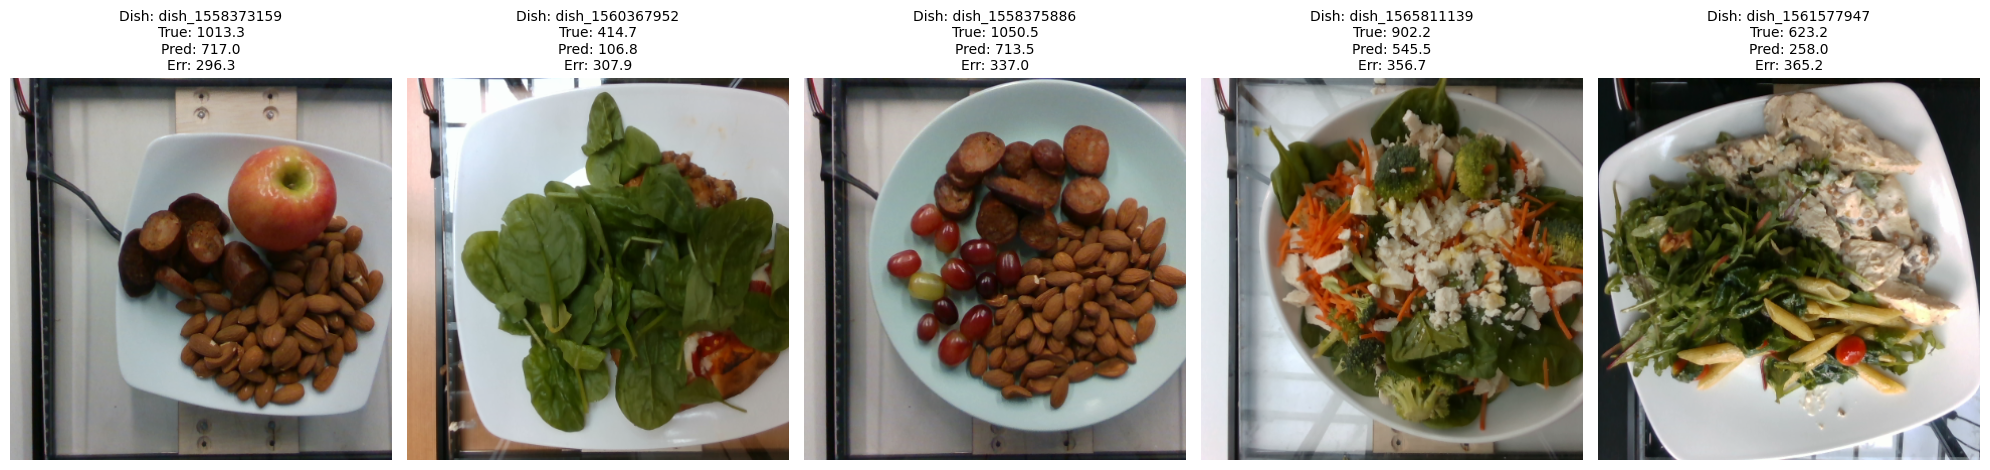

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(top5_idx):
    item = test_dataset[idx]
    img = item["image"]
    
    # Денормализация изображения
    img_np = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)
    
    label = item["label"]
    dish_id = test_dataset.df.loc[idx, "dish_id"]
    
    axes[i].imshow(img_np)
    axes[i].axis("off")
    axes[i].set_title(
        f"Dish: {dish_id}\nTrue: {all_labels[idx]:.1f}\nPred: {all_preds[idx]:.1f}\nErr: {errors[idx]:.1f}",
        fontsize=10
    )

plt.tight_layout()
plt.show()


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-warning">
    
⚠️ Видно, что твоя модель всегда ошибается в меньшую сторону, возможно есть систематическая ошибка. 
Просьба добавить графики распределения таргета и предсказанных значений.                                                         
                                                               
</div>

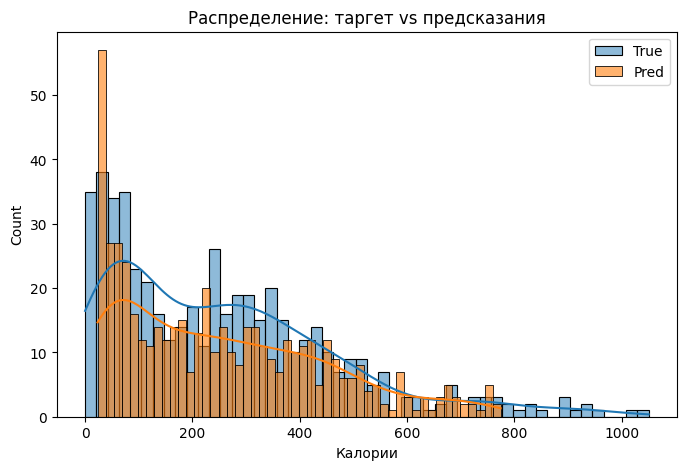

d:\Нейросети яндекс практикум\multimodal_calory_dish\.venv\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



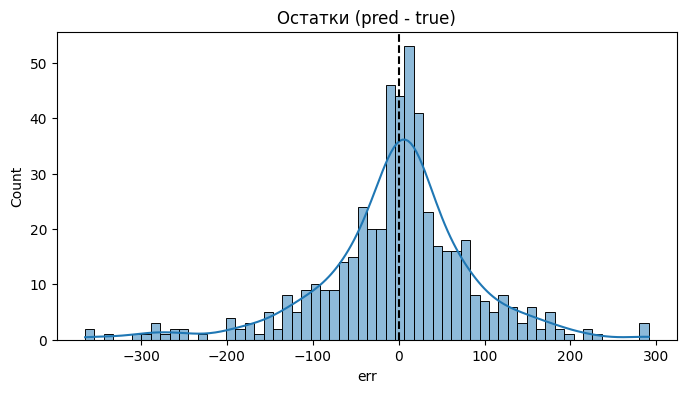

In [13]:
df_test = pd.DataFrame({
    "true": np.array(all_labels).flatten(),
    "pred": np.array(all_preds).flatten()
})
df_test["err"] = df_test["pred"] - df_test["true"]


plt.figure(figsize=(8,5))
sns.histplot(df_test["true"], bins=50,  kde=True,  label="True") # type: ignore
sns.histplot(df_test["pred"], bins=50,  kde=True,  label="Pred", alpha=0.6) # type: ignore
plt.title("Распределение: таргет vs предсказания")
plt.xlabel("Калории")
plt.legend()
plt.show()


plt.figure(figsize=(8,4))
sns.histplot(df_test["err"], bins=60, kde=True) # type: ignore
plt.axvline(0, color="k", linestyle="--")
plt.title("Остатки (pred - true)")
plt.show()

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Модель и вправду занижает коллории и вовсе не видит больше 800.
Ссылка на репозиторий - https://github.com/diyudd/multimodal_calory_dish
</div>